In [1]:
import numpy as np
rng = np.random.default_rng(2025)

import matplotlib.pyplot as plt

In [2]:
import torch
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference import SNPE
from sbi.utils import get_density_thresholder, RestrictedPrior

from tqdm import tqdm


/home/janko/code/drawer/mines/mines-venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import jax
import jax.numpy as jnp

In [28]:
from multiprocessing import Pool

The simulator

In [29]:
def f(theta):
    return 10*jnp.sin(5*theta[0]/3.14) * 10*jnp.sin(theta[1]/3.14) + (theta[0]-1)**2 + 2*(theta[1]-1)**2

def f(theta):
    return -1/(1+theta[0]**2) - 1 /(3 + 5*(theta[1]-3)**2)

# def f(theta):
#     return -jnp.exp(-theta[0]**2/5 - theta[1]**2/5) + jnp.exp(-(theta[0]-1)**2/5 - (theta[1]-4)**2/5)

def simulator(thetas):
    
    print('Simulating...', end='')

    thetas = jnp.array(thetas)

    xs = []
    for theta in tqdm(thetas):
        v, g = jax.value_and_grad(f)(theta)
        xs.append([*g])

    xs = np.stack(xs)
    xs = torch.tensor(xs, dtype=torch.float32)

    print('finished')

    return xs

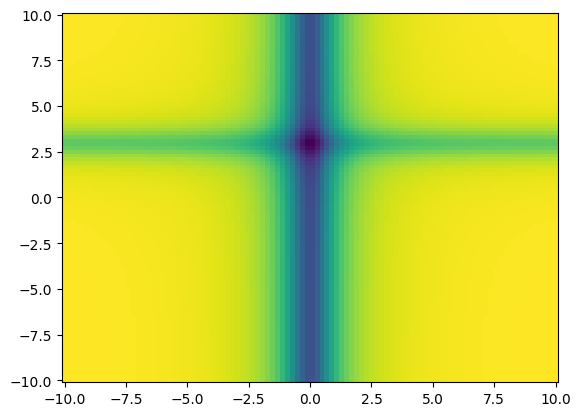

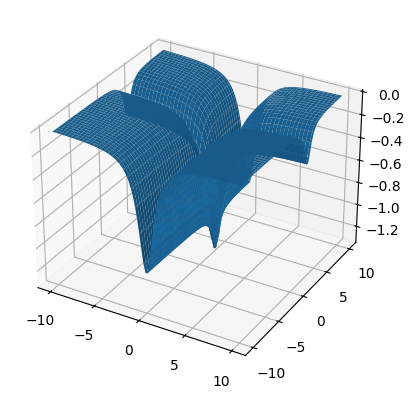

In [23]:
x = np.linspace(-10,10,100)
y = np.linspace(-10,10,100)

xx, yy = np.meshgrid(x,y)
zz = f((xx,yy))

plt.pcolor(xx,yy,zz)
ax = plt.figure().add_subplot(projection='3d')
ax.plot_surface(xx,yy,zz)

In [30]:
num_dim = 2
prior = utils.BoxUniform(low=-10 * torch.ones(num_dim), high=10 * torch.ones(num_dim))

inference = SNPE(prior)
proposal = prior

observation = (0.,0.)

for _ in range(3):
    theta = proposal.sample((10000,))
    x = simulator(theta)
    _ = inference.append_simulations(theta, x).train(force_first_round_loss=True)
    posterior = inference.build_posterior().set_default_x(observation)

    accept_reject_fn = get_density_thresholder(posterior, quantile=1e-4, num_samples_to_estimate_support=10_000)
    proposal = RestrictedPrior(prior, accept_reject_fn, sample_with="rejection")


# for _ in range(3):
#     theta = proposal.sample((1000,))
#     x = simulator(theta)
#     _ = inference.append_simulations(theta, x, proposal=proposal).train()
#     posterior = inference.build_posterior().set_default_x(observation)
#     proposal = posterior

Simulating...

100%|██████████| 10000/10000 [00:40<00:00, 246.13it/s]


finished
 Neural network successfully converged after 149 epochs.

Drawing 10000 posterior samples: 11976it [00:00, 492523.41it/s]           


The `RestrictedPrior` rejected 30.7% of prior samples. You will get a speed-up of 44.2%.
Simulating...

100%|██████████| 10000/10000 [00:40<00:00, 244.16it/s]


finished
 Neural network successfully converged after 213 epochs.

Drawing 10000 posterior samples: 10039it [00:00, 182538.13it/s]           


The `RestrictedPrior` rejected 84.2% of prior samples. You will get a speed-up of 534.1%.
Simulating...

100%|██████████| 10000/10000 [00:41<00:00, 242.48it/s]


finished
 Neural network successfully converged after 72 epochs.

Drawing 10000 posterior samples:   7%|▋         | 707/10000 [00:00<00:02, 3251.92it/s]WARNING:root:Only 0.490% proposal samples are
                    accepted. It may take a long time to collect the remaining
                    8972 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.
Drawing 10000 posterior samples: 10020it [00:03, 2980.93it/s]                          
                        constant for `log_prob()`. However, only
                        0.483% posterior samples are within the
                        prior support (for condition 0). It may take a long time
                        to collect the remaining 8986 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where

Drawing 10000 posterior samples:  11%|█         | 1055/10000 [00:00<00:02, 3140.69it/s]WARNING:root:Only 0.502% proposal samples are
                    accepted. It may take a long time to collect the remaining
                    8945 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.
Drawing 10000 posterior samples: 10008it [00:03, 3229.47it/s]                          


torch.Size([10000])


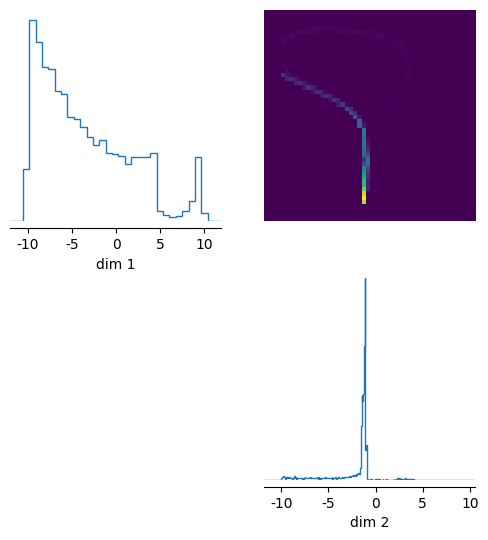

In [31]:
samples = posterior.sample((10000,), x=observation)
print(posterior.log_prob(samples, x=observation).shape)
_ = analysis.pairplot(samples, figsize=(6, 6))

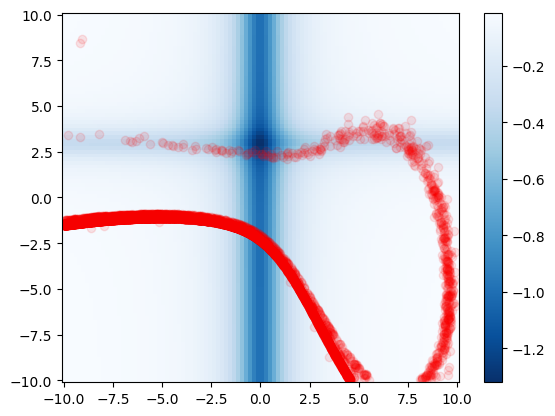

In [32]:
plt.pcolor(xx,yy,zz, cmap='Blues_r')
plt.colorbar()

plt.scatter(*samples.numpy().T, alpha=0.1, color='red')